In [141]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from scipy.stats import kurtosis
import time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import datetime
import matplotlib.pyplot as plt

In [2]:
import pandarallel as pdl
pdl.pandarallel.initialize(10000)

New pandarallel memory created - Size: 10000 MB
Pandarallel will run on 88 workers


In [3]:
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

In [4]:
train_df = pd.read_csv('dataset/train.csv', parse_dates=['auditing_date', 'due_date', 'repay_date'])

In [5]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,\N,\N
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503


In [6]:
def plus_1_day(s):
    return s + datetime.timedelta(days=1)

In [7]:
# 如果违约,还款日期为due_date的后一天
train_df['repay_date'] = train_df[['due_date', 'repay_date']].apply(
    lambda x: x['repay_date'] if x['repay_date'] != '\\N' else plus_1_day(x['due_date']), axis=1
)

In [8]:
# 如果违约,还款金额为0
train_df['repay_amt'] = train_df['repay_amt'].apply(lambda x: x if x != '\\N' else 0).astype('float32')

In [9]:
# 设定label
train_df['label'] = (train_df['due_date'] - train_df['repay_date']).dt.days

In [10]:
train_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt,label
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.116699,0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.704498,1
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2018-03-19,0.000000,-1
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.980896,0
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.650299,6


In [11]:
train_df['label'].value_counts(sort=False)

 0     408187
 1     121085
 2      59430
 3      56404
 4      26425
 5      21380
 6      17568
 7      14797
 8      12993
 9      11393
 10      9984
 11      9002
 12      8219
 13      7688
 14      6920
 15      6443
 16      6231
 17      5832
 18      5492
 19      5108
 20      4788
 21      4504
 22      4295
 23      4197
 24      3922
 25      3934
 26      3930
 27      4102
 28      4677
 29      5645
 30      9865
 31      8368
-1     117192
Name: label, dtype: int64

In [12]:
train_df['label'].nunique()

33

In [13]:
# 为什么要把-1换作32:方便分类编号和日期对应
# train_df.loc[train_df['repay_amt'] == -1, 'label'] = 32 错误写法
train_df['label'].replace(-1, 32, inplace=True)

In [14]:
clf_labels = train_df['label'].values

In [15]:
clf_labels.shape

(1000000,)

In [16]:
amt_labels = train_df['repay_amt'].values

In [17]:
del train_df['label'], train_df['repay_amt'], train_df['repay_date']

In [18]:
train_due_amt_df = train_df[['due_amt']]

In [19]:
train_num = train_df.shape[0]

In [20]:
test_df = pd.read_csv('dataset/test.csv', parse_dates=['auditing_date', 'due_date'])

In [21]:
test_df.head()

,user_id,listing_id,auditing_date,due_date,due_amt
0,498765,5431438,2019-03-12,2019-04-12,138.5903
1,34524,5443211,2019-03-15,2019-04-15,208.0805
2,821741,5461707,2019-03-22,2019-04-22,421.2097
3,263534,5472320,2019-03-26,2019-04-26,212.6537
4,238853,5459750,2019-03-21,2019-04-21,817.4593


In [22]:
sub = test_df[['user_id', 'listing_id', 'auditing_date', 'due_amt', 'due_date']]

In [23]:
sub.head()

,user_id,listing_id,auditing_date,due_amt,due_date
0,498765,5431438,2019-03-12,138.5903,2019-04-12
1,34524,5443211,2019-03-15,208.0805,2019-04-15
2,821741,5461707,2019-03-22,421.2097,2019-04-22
3,263534,5472320,2019-03-26,212.6537,2019-04-26
4,238853,5459750,2019-03-21,817.4593,2019-04-21


In [24]:
test_df.shape

(130000, 5)

In [25]:
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [26]:
df.shape

(1130000, 5)

In [27]:
df_listing_id = df['listing_id']

# *listing_info*

In [28]:
listing_info_df = pd.read_csv('dataset/listing_info.csv')

In [29]:
listing_info_df.head()

,user_id,listing_id,auditing_date,term,rate,principal
0,316610,1556649,2017-11-26,9,7.6,4800
1,62002,1556633,2017-11-26,6,7.6,4000
2,192135,1556629,2017-11-26,12,8.0,8660
3,487382,1556628,2017-11-26,9,7.6,4780
4,235186,1556627,2017-11-26,9,7.6,1480


In [30]:
del listing_info_df['user_id'], listing_info_df['auditing_date']

In [31]:
listing_info_df.head()

,listing_id,term,rate,principal
0,1556649,9,7.6,4800
1,1556633,6,7.6,4000
2,1556629,12,8.0,8660
3,1556628,9,7.6,4780
4,1556627,9,7.6,1480


## 基于listing_info的特征

In [32]:
listing_info_df['平均每月借款金额'] = listing_info_df['principal'] / listing_info_df['term']

In [33]:
listing_info_df.head()

,listing_id,term,rate,principal,平均每月借款金额
0,1556649,9,7.6,4800,533.333333
1,1556633,6,7.6,4000,666.666667
2,1556629,12,8.0,8660,721.666667
3,1556628,9,7.6,4780,531.111111
4,1556627,9,7.6,1480,164.444444


In [34]:
df = df.merge(listing_info_df, on='listing_id', how='left')

In [35]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111
2,404196,2355665,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889
3,342769,1994522,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556
4,828139,3602352,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000


In [36]:
cate_cols2 = []

In [37]:
df['总还款金额'] = df['term'] * df['due_amt']
df['总利息'] = df['总还款金额'] - df['principal']
df['每月利息'] = df['总利息'] / df['term']
df['总利息/总还款金额'] = df['总利息'] / df['总还款金额']
df['平均每月借款金额/due_amt'] = df['平均每月借款金额'] / df['due_amt']
df['总利息/principal'] = df['总利息'] / df['principal']
df['总利息/总还款金额'] = df['总利息'] / df['总还款金额']
df['还款期限'] = (df['due_date'] - df['auditing_date']).dt.days
df['首期平均每日还款'] = df['due_amt'] / df['还款期限']
df['due_date星期几'] = df['due_date'].dt.dayofweek
df['auditing_date星期几'] = df['auditing_date'].dt.dayofweek
# 这2个特征下面有处理
# df['due_date是当月第几日'] = df['due_date'].dt.day
# df['auditing_date是当月第几日'] = df['auditing_date'].dt.day

In [38]:
cate_cols2.append('due_date星期几')
cate_cols2.append('auditing_date星期几')
cate_cols2.append('还款期限')

In [39]:
df.head()

,user_id,listing_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限,首期平均每日还款,due_date星期几,auditing_date星期几
0,748147,3163926,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2
1,672952,3698760,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5
2,404196,2355665,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6
3,342769,1994522,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5
4,828139,3602352,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4


# *user_info*

In [40]:
user_info_df = pd.read_csv('dataset/user_info.csv', parse_dates=['reg_mon', 'insertdate'])

In [41]:
user_info_df.head()

,user_id,reg_mon,gender,age,cell_province,id_province,id_city,insertdate
0,483833,2017-04-01,男,19,c29,c26,c26241,2018-12-11
1,156772,2016-05-01,男,31,c11,c11,c11159,2018-02-13
2,173388,2016-05-01,男,34,c02,c02,c02182,2018-08-21
3,199107,2016-07-01,女,25,c09,c09,c09046,2018-06-05
4,122560,2016-03-01,男,23,c05,c05,c05193,2018-04-02


In [42]:
user_info_df.rename(columns={'insertdate': 'info_insert_date'}, inplace=True)

通过一个时间对比控制不使用未来数据

In [43]:
def merge_before_auditing(df, df2, df2_time='info_insert_date', on='user_id'):
    df3 = df.merge(df2, on=on, how='left')
    # 不必选出有空值的行，最后一步能顾及到（乐）
    df4 = df3[(df3['auditing_date']>=df3[df2_time])]
    df5 = df.merge(df4, on=df.columns.tolist(), how='left')
    return df5

In [44]:
df = merge_before_auditing(df, user_info_df, df2_time='info_insert_date', on='user_id')

In [45]:
df = df.sort_values(by='info_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [46]:
df['注册时间距离贷款'] = (df['auditing_date'] - df['reg_mon']).dt.days

In [47]:
df['注册时间距个人信息更新时间'] = (df['info_insert_date'] - df['reg_mon']).dt.days

In [48]:
df['手机号和身份证是否同意城市'] = (df['cell_province'] == df['id_province']).apply(lambda s: 1 if s is True else 0)

In [49]:
df.shape

(1130000, 29)

In [50]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_taglist*

In [51]:
user_tag_df = pd.read_csv('dataset/user_taglist.csv', parse_dates=['insertdate'])

In [52]:
user_tag_df.head()

,user_id,taglist,insertdate
0,113401,4707|473|3498|4759|1654|298|2869|1164|212|1885...,2018-10-03
1,378358,751|2207|1100|2099|1832|1911|5347|2254|171|360...,2018-11-30
2,434838,877|3795|5628|70|2684|691|719|4228|631|1541|12...,2018-03-25
3,577061,2431|3242|340|1823|4020|4357|164|620|2168|1192...,2018-05-25
4,566753,3980|3125|1819|1333|1177|3972|621|5800|3632|16...,2018-12-02


In [53]:
user_tag_df.rename(columns={'insertdate': 'tag_insert_date'}, inplace=True)

user_tag_df也不能都用最新的数据

In [54]:
df = merge_before_auditing(df, user_tag_df, df2_time='tag_insert_date', on='user_id')

In [55]:
df = df.sort_values(by='tag_insert_date', ascending=False).drop_duplicates('listing_id').sort_index().reset_index(drop=True)

In [56]:
df.shape

(1130000, 31)

In [57]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_behavior_logs*

In [58]:
user_behavior_df = pd.read_csv('dataset/user_behavior_logs.csv', parse_dates=['behavior_time'])

In [59]:
user_behavior_df.head()

,user_id,behavior_time,behavior_type
0,842439,2018-09-13 23:17:21,3
1,842439,2018-09-13 23:17:21,3
2,905214,2018-09-13 15:19:30,3
3,905214,2018-09-13 15:19:30,3
4,842439,2018-09-13 23:17:21,3


In [60]:
user_bh_df = user_behavior_df.set_index('user_id')

In [61]:
df2 = df[['user_id', 'listing_id', 'auditing_date']].copy()

In [62]:
df3 = merge_before_auditing(df2, user_behavior_df, df2_time='behavior_time', on = 'user_id' )

In [63]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0


In [64]:
df.set_index('listing_id', inplace = True)

In [65]:
def length(a):
    return len(a)

In [66]:
%%time
df['behavior的个数'] = df3.groupby('listing_id').progress_apply(length)

# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['behavior为1的个数'] = df3[df3['behavior_type']==1].groupby('listing_id').progress_apply(length)
df['behavior为2的个数'] = df3[df3['behavior_type']==2].groupby('listing_id').progress_apply(length)
df['behavior为3的个数'] = df3[df3['behavior_type']==3].groupby('listing_id').progress_apply(length)


# df5['behavior为2的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==2]))
# df5['behavior为3的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==3]))
df['behavior的个数'].fillna(0, inplace=True)
df['behavior为1的个数'].fillna(0, inplace=True)
df['behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 1min 13s, sys: 38.7 s, total: 1min 52s
Wall time: 28.9 s


In [67]:
df.head()

,user_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限,首期平均每日还款,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,注册时间距离贷款,注册时间距个人信息更新时间,手机号和身份证是否同意城市,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数
listing_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3163926,748147,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0
3698760,672952,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0
2355665,404196,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0
1994522,342769,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,30,30.0,0.0,0.0
3602352,828139,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,37,12.0,1.0,24.0


In [68]:
df3['dayofmonth'] = df3['behavior_time'].dt.day

In [69]:
df3.head()

,user_id,listing_id,auditing_date,behavior_time,behavior_type,dayofmonth
0,748147,3163926,2018-04-25,2018-04-22 21:29:09,1.0,22.0
1,748147,3163926,2018-04-25,2018-04-22 21:05:09,1.0,22.0
2,748147,3163926,2018-04-25,2018-04-22 20:57:50,1.0,22.0
3,748147,3163926,2018-04-25,2018-04-22 20:58:19,2.0,22.0
4,748147,3163926,2018-04-25,2018-02-24 08:20:35,1.0,24.0


In [70]:
df3['days'] = (df3['auditing_date']-df3['behavior_time']).dt.days

In [71]:
df7 = df3[(df3['days']>=0)&(df3['days']<30)]

In [72]:
df7.shape

(12945727, 7)

In [73]:
%%time
df['1月内behavior的个数'] = df7.groupby('listing_id').progress_apply(length)
# df5['behavior为1的个数'] = df3.groupby('listing_id').progress_apply(lambda s: len(s[s['behavior_type']==1]))
df['1月内behavior为1的个数'] = df7[df7['behavior_type']==1].groupby('listing_id').progress_apply(length)                                                    
df['1月内behavior为2的个数'] = df7[df7['behavior_type']==2].groupby('listing_id').progress_apply(length)                                                 
df['1月内behavior为3的个数'] = df7[df7['behavior_type']==3].groupby('listing_id').progress_apply(length)
df['1月内behavior的个数'].fillna(0, inplace=True)
df['1月内behavior为1的个数'].fillna(0, inplace=True)
df['1月内behavior为2的个数'].fillna(0, inplace=True)                                                                 
df['1月内behavior为3的个数'].fillna(0, inplace=True)


CPU times: user 33 s, sys: 15.2 s, total: 48.3 s
Wall time: 13.4 s


In [74]:
df.reset_index(inplace=True)

In [75]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限,首期平均每日还款,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,注册时间距离贷款,注册时间距个人信息更新时间,手机号和身份证是否同意城市,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数
0,3163926,748147,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0
1,3698760,672952,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0,2.0,2.0,0.0,0.0
2,2355665,404196,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0,3.0,3.0,0.0,0.0
3,1994522,342769,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,30,30.0,0.0,0.0,2.0,2.0,0.0,0.0
4,3602352,828139,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,37,12.0,1.0,24.0,2.0,2.0,0.0,0.0


In [76]:
df.shape

(1130000, 39)

In [77]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

# *user_repay_logs*

In [78]:
repay_log_df = pd.read_csv('dataset/user_repay_logs.csv', parse_dates=['due_date', 'repay_date'])

In [79]:
repay_log_df = repay_log_df[repay_log_df['order_id'] == 1].reset_index(drop=True)

In [80]:
repay_log_df.sort_values(by='due_date',ascending=False).head()

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
2544012,882692,5482798,1,2019-04-30,576.0161,2019-03-30,576.0161
2117425,785337,5481718,1,2019-04-30,144.3660,2019-03-30,144.3660
1459650,882692,5482750,1,2019-04-30,195.7588,2019-03-30,195.7588
2143042,920572,5481601,1,2019-04-30,107.0008,2019-03-30,107.0008
2339237,882692,5482707,1,2019-04-30,195.7588,2019-03-30,195.7588


In [81]:
def getRepay(date):
    if date!='2200-01-01':
        return 1
    else:
        return 0

# repay: 0[expired] 1[on time]
repay_log_df['repay'] = repay_log_df['repay_date'].astype('str').parallel_apply(getRepay)

In [82]:
repay_log_df['early_repay_days'] = (repay_log_df['due_date'] - repay_log_df['repay_date']).dt.days

In [83]:
repay_log_df['early_repay_days'] = repay_log_df['early_repay_days'].apply(lambda x: x if x >= 0 else -1)

In [84]:
def adjustDate(df):
    if df['repay_date']!=datetime.datetime(2200,1,1):
        return df['repay_date']
    else:
        return df['due_date']

repay_log_df['repay_date'] = repay_log_df[['repay_date','due_date']].parallel_apply(adjustDate, axis=1)

In [85]:
def divide(df):
    if df['early_repay_days'] < 0:
        return df['due_amt']/df['early_repay_days']
    else:
        return df['due_amt']/(df['early_repay_days']+1)

repay_log_df['due_amt/early_repay_date'] = repay_log_df[['due_amt','early_repay_days']].parallel_apply(divide, axis=1)

In [86]:
repay_log_df.head(10)

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt,repay,early_repay_days,due_amt/early_repay_date
0,748483,1858122,1,2018-01-29,528.6365,2018-01-28,528.6365,1,1,264.318250
1,369368,3900565,1,2018-08-03,385.5078,2018-07-22,385.5078,1,12,29.654446
2,749102,1699160,1,2018-01-11,338.5357,2017-12-11,338.5357,1,31,10.579241
3,385257,2204015,1,2018-03-03,1106.1967,2018-03-02,1106.1967,1,1,553.098350
4,648677,3811960,1,2018-07-23,385.5078,2018-07-04,385.5078,1,19,19.275390
5,46421,3493073,1,2018-06-22,423.7665,2018-06-21,423.7665,1,1,211.883250
6,237430,4058618,1,2018-08-23,212.5250,2018-08-23,212.5250,0,-1,-212.525000
7,391438,3266118,1,2018-06-03,385.8409,2018-06-03,385.8409,1,0,385.840900
8,289893,1114293,1,2017-11-06,1020.1285,2017-11-06,1020.1285,1,0,1020.128500
9,106403,1152391,1,2017-11-10,425.6166,2017-11-10,425.6166,1,0,425.616600


In [87]:
# 删除'listing_id', 'order_id', 'due_date','repay_amt'，保留'repay_date'以便之后的时间对比
for f in ['listing_id', 'order_id', 'due_date','repay_amt']:
    del repay_log_df[f]

In [88]:
repay_log_df = repay_log_df.rename(columns={'due_amt':'log_due_amt', 'repay_date':'log_repay_date'})

In [89]:
repay_log_df.head()

,user_id,log_due_amt,log_repay_date,repay,early_repay_days,due_amt/early_repay_date
0,748483,528.6365,2018-01-28,1,1,264.318250
1,369368,385.5078,2018-07-22,1,12,29.654446
2,749102,338.5357,2017-12-11,1,31,10.579241
3,385257,1106.1967,2018-03-02,1,1,553.098350
4,648677,385.5078,2018-07-04,1,19,19.275390


In [90]:
df.shape

(1130000, 39)

In [91]:
 df = merge_before_auditing(df, repay_log_df, df2_time='log_repay_date', on='user_id')

In [92]:
group = df.groupby('listing_id', as_index=False)

In [93]:
group.ngroups

1130000

In [94]:
df = df.merge(
    group['repay'].agg({'repay_mean': 'mean'}), on='listing_id', how='left'
)

In [95]:
df = df.merge(
    group['due_amt/early_repay_date'].agg({
        'due_amt/early_repay_date_mean': 'mean', 'due_amt/early_repay_date_std': 'std', 'due_amt/early_repay_date_median': 'median',
        'due_amt/early_repay_date_max':'max', 'due_amt/early_repay_date_min': 'min'}), on='listing_id', how='left'
)

In [96]:
df = df.merge(
    group['early_repay_days'].agg({
        'early_repay_days_max': 'max', 'early_repay_days_min': 'min', 'early_repay_days_median': 'median', 
        'early_repay_days_sum': 'sum', 'early_repay_days_mean': 'mean', 'early_repay_days_std': 'std'
    }), on='listing_id', how='left'
)

In [98]:
df = df.merge(
    group['log_due_amt'].agg({
        'due_amt_max': 'max', 'due_amt_min': 'min', 'due_amt_median': 'median',
        'due_amt_mean': 'mean', 'due_amt_sum': 'sum', 'due_amt_std': 'std',
        'due_amt_skew': 'skew', 'due_amt_kurt': kurtosis, 'due_amt_ptp': np.ptp
    }), on='listing_id', how='left'
)

In [99]:
df = df.drop_duplicates('listing_id').reset_index(drop=True)

In [100]:
df.head()

,listing_id,user_id,auditing_date,due_date,due_amt,term,rate,principal,平均每月借款金额,总还款金额,总利息,每月利息,总利息/总还款金额,平均每月借款金额/due_amt,总利息/principal,还款期限,首期平均每日还款,due_date星期几,auditing_date星期几,reg_mon,gender,age,cell_province,id_province,id_city,info_insert_date,注册时间距离贷款,注册时间距个人信息更新时间,手机号和身份证是否同意城市,taglist,tag_insert_date,behavior的个数,behavior为1的个数,behavior为2的个数,behavior为3的个数,1月内behavior的个数,1月内behavior为1的个数,1月内behavior为2的个数,1月内behavior为3的个数,log_due_amt,log_repay_date,repay,early_repay_days,due_amt/early_repay_date,repay_mean,due_amt/early_repay_date_mean,due_amt/early_repay_date_std,due_amt/early_repay_date_median,due_amt/early_repay_date_max,due_amt/early_repay_date_min,early_repay_days_max,early_repay_days_min,early_repay_days_median,early_repay_days_sum,early_repay_days_mean,early_repay_days_std,due_amt_max,due_amt_min,due_amt_median,due_amt_mean,due_amt_sum,due_amt_std,due_amt_skew,due_amt_kurt,due_amt_ptp
0,3163926,748147,2018-04-25,2018-05-25,72.1167,9,7.2,630,70.000000,649.0503,19.0503,2.116700,0.029351,0.970649,0.030239,30,2.403890,4,2,2017-12-01,男,21,c20,c20,c20089,2018-04-24,145,144,1,4706|3778|1058|3067|4481|1654|956|1478|2540|11...,2018-04-24,52,11.0,2.0,39.0,18.0,5.0,1.0,12.0,102.1022,2018-04-24,1.0,28.0,3.520766,1.0,3.520766,NaN,3.520766,3.520766,3.520766,28.0,28.0,28.0,28.0,28.0,NaN,102.1022,102.1022,102.1022,102.102200,102.1022,NaN,NaN,-3.000000,0.0000
1,3698760,672952,2018-06-09,2018-07-09,258.7045,9,7.2,2260,251.111111,2328.3405,68.3405,7.593389,0.029352,0.970648,0.030239,30,8.623483,0,5,2017-09-01,男,37,c14,c17,c17250,2018-06-04,281,276,0,1421|3116|5145|5201|2785|1812|4671|3125|1058|2...,2018-06-04,52,29.0,0.0,23.0,2.0,2.0,0.0,0.0,133.9311,2018-06-05,1.0,1.0,66.965550,1.0,235.094905,397.869326,66.965550,945.006200,10.302392,12.0,0.0,1.0,16.0,3.2,4.969909,945.0062,133.9311,133.9311,321.100800,1605.5040,352.933682,2.113048,0.126236,811.0751
2,2355665,404196,2018-02-18,2018-03-18,307.9270,9,7.2,2690,298.888889,2771.3430,81.3430,9.038111,0.029351,0.970649,0.030239,28,10.997393,6,6,2017-02-01,男,24,c04,c04,c04251,2018-02-17,382,381,1,4617|436|1338|3871|1667|2828|4121|1478|1654|30...,2018-02-17,8,8.0,0.0,0.0,3.0,3.0,0.0,0.0,307.9270,2018-02-04,1.0,24.0,12.317080,0.5,-45.081960,81.174501,-45.081960,12.317080,-102.481000,24.0,-1.0,11.5,23.0,11.5,17.677670,307.9270,102.4810,205.2040,205.204000,410.4080,145.272260,NaN,-2.000000,205.4460
3,1994522,342769,2018-01-13,2018-02-13,252.9809,9,7.2,2210,245.555556,2276.8281,66.8281,7.425344,0.029351,0.970649,0.030239,31,8.160674,1,5,2016-12-01,男,23,c17,c17,c17246,2018-01-12,408,407,1,1100|472|3422|3296|4949|4025|3328|974|4092|218...,2018-01-12,30,30.0,0.0,0.0,2.0,2.0,0.0,0.0,622.6028,2017-10-12,1.0,1.0,311.301400,1.0,230.637147,79.844025,228.970600,311.301400,151.639440,4.0,1.0,1.0,6.0,2.0,1.732051,758.1972,457.9412,622.6028,612.913733,1838.7412,150.362312,-0.288768,-1.500000,300.2560
4,3602352,828139,2018-06-01,2018-07-01,107.6503,6,8.6,630,105.000000,645.9018,15.9018,2.650300,0.024620,0.975380,0.025241,30,3.588343,6,4,2018-04-01,男,23,c02,c17,c17096,2018-05-31,61,60,0,5784|3643|2017|3432|469|5151|1625|1753|2762|15...,2018-05-31,37,12.0,1.0,24.0,2.0,2.0,0.0,0.0,148.9888,2018-05-04,1.0,0.0,148.988800,1.0,148.988800,NaN,148.988800,148.988800,148.988800,0.0,0.0,0.0,0.0,0.0,NaN,148.9888,148.9888,148.9888,148.988800,148.9888,NaN,NaN,-3.000000,0.0000


In [101]:
del df['repay'], df['early_repay_days'], df['log_due_amt'],df['log_repay_date'],df['due_amt/early_repay_date']

In [102]:
df.shape

(1130000, 60)

In [103]:
np.where((df['listing_id'] == df_listing_id)==False)

(array([], dtype=int64),)

In [104]:
cate_cols = ['gender', 'cell_province', 'id_province', 'id_city']

In [105]:
# 这个lgb应该有参数可以直接传 lgb.train(categorical_feature=cate_cols)
for f in cate_cols:
    df[f] = df[f].map(dict(zip(df[f].unique(), range(df[f].nunique())))).astype('int32')

In [106]:
df['due_amt_per_days'] = df['due_amt'] / (train_df['due_date'] - train_df['auditing_date']).dt.days

In [107]:
date_cols = ['auditing_date', 'due_date', 'reg_mon', 'info_insert_date', 'tag_insert_date']

In [108]:
for f in date_cols:
    if f in ['reg_mon', 'info_insert_date', 'tag_insert_date']:
        df[f + '_year'] = df[f].dt.year
    df[f + '_month'] = df[f].dt.month
    if f in ['auditing_date', 'due_date', 'info_insert_date', 'tag_insert_date']:
        df[f + '_day'] = df[f].dt.day
        df[f + '_dayofweek'] = df[f].dt.dayofweek

In [109]:
df.drop(columns=date_cols, axis=1, inplace=True)

In [110]:
df['big_month'] = df['auditing_date_month'].apply(lambda x: 1 if x in [1,3,5,7,8,10,12] else 0)
df['February'] = df['auditing_date_month'].apply(lambda x: 1 if x==2 else 0)

In [111]:
# one-hot encoding for tags
df['taglist'] = df['taglist'].astype('str').apply(lambda x: x.strip().replace('|', ' ').strip())

In [112]:
vectorizer = CountVectorizer(min_df=10, max_df=0.9)
tag_cv = vectorizer.fit_transform(df['taglist'])

In [113]:
del df['user_id'], df['listing_id'], df['taglist']

In [114]:
# 也可以用lgb.train(categorical_features=cate_cols)
df = pd.get_dummies(df, columns=cate_cols)
df = pd.get_dummies(df, columns=cate_cols2)

In [115]:
feature_name = np.concatenate((df.keys(),vectorizer.get_feature_names()))

In [116]:
df = sparse.hstack((df.values, tag_cv), format='csr', dtype='float32')

In [117]:
train_values, test_values = df[:train_num], df[train_num:]

In [118]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
clf = LGBMClassifier(
    n_jobs=87,
    learning_rate=0.05,
    n_estimators=10000,
    subsample=0.8,
    subsample_freq=1,
    colsample_bytree=0.8,
    random_state=2019
)
amt_oof = np.zeros(train_num)
prob_oof = np.zeros((train_num, 33))
test_pred_prob = np.zeros((test_values.shape[0], 33))
for i, (trn_idx, val_idx) in enumerate(skf.split(train_values, clf_labels)):
    print(i, 'fold...')
    t = time.time()

    trn_x, trn_y = train_values[trn_idx], clf_labels[trn_idx]
    val_x, val_y = train_values[val_idx], clf_labels[val_idx]
    val_repay_amt = amt_labels[val_idx]
    val_due_amt = train_due_amt_df.iloc[val_idx]

    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        early_stopping_rounds=100, verbose=5, feature_name=list(feature_name)
    )
    # shape = (-1, 33)
    val_pred_prob_everyday = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    prob_oof[val_idx] = val_pred_prob_everyday
    val_pred_prob_today = [val_pred_prob_everyday[i][val_y[i]] for i in range(val_pred_prob_everyday.shape[0])]
    val_pred_repay_amt = val_due_amt['due_amt'].values * val_pred_prob_today
    print('val rmse:', np.sqrt(mean_squared_error(val_repay_amt, val_pred_repay_amt)))
    print('val mae:', mean_absolute_error(val_repay_amt, val_pred_repay_amt))
    amt_oof[val_idx] = val_pred_repay_amt
    test_pred_prob += clf.predict_proba(test_values, num_iteration=clf.best_iteration_) / skf.n_splits

    print('runtime: {}\n'.format(time.time() - t))

print('\ncv rmse:', np.sqrt(mean_squared_error(amt_labels, amt_oof)))
print('cv mae:', mean_absolute_error(amt_labels, amt_oof))
print('cv logloss:', log_loss(clf_labels, prob_oof))
print('cv acc:', accuracy_score(clf_labels, np.argmax(prob_oof, axis=1)))

0 fold...
Training until validation scores don't improve for 100 rounds.
[5]	valid_0's multi_logloss: 2.95328	valid_1's multi_logloss: 2.95586
[10]	valid_0's multi_logloss: 2.71521	valid_1's multi_logloss: 2.72023
[15]	valid_0's multi_logloss: 2.5645	valid_1's multi_logloss: 2.57185
[20]	valid_0's multi_logloss: 2.45895	valid_1's multi_logloss: 2.46867
[25]	valid_0's multi_logloss: 2.3811	valid_1's multi_logloss: 2.39316
[30]	valid_0's multi_logloss: 2.32191	valid_1's multi_logloss: 2.33633
[35]	valid_0's multi_logloss: 2.27583	valid_1's multi_logloss: 2.29266
[40]	valid_0's multi_logloss: 2.23933	valid_1's multi_logloss: 2.25861
[45]	valid_0's multi_logloss: 2.21003	valid_1's multi_logloss: 2.23181
[50]	valid_0's multi_logloss: 2.18617	valid_1's multi_logloss: 2.21056
[55]	valid_0's multi_logloss: 2.16659	valid_1's multi_logloss: 2.19357
[60]	valid_0's multi_logloss: 2.15025	valid_1's multi_logloss: 2.17987
[65]	valid_0's multi_logloss: 2.13643	valid_1's multi_logloss: 2.16884
[70]	va

[65]	valid_0's multi_logloss: 2.13619	valid_1's multi_logloss: 2.16898
[70]	valid_0's multi_logloss: 2.12441	valid_1's multi_logloss: 2.16004
[75]	valid_0's multi_logloss: 2.1142	valid_1's multi_logloss: 2.15276
[80]	valid_0's multi_logloss: 2.1052	valid_1's multi_logloss: 2.14676
[85]	valid_0's multi_logloss: 2.09723	valid_1's multi_logloss: 2.14186
[90]	valid_0's multi_logloss: 2.09009	valid_1's multi_logloss: 2.13783
[95]	valid_0's multi_logloss: 2.08358	valid_1's multi_logloss: 2.13451
[100]	valid_0's multi_logloss: 2.07757	valid_1's multi_logloss: 2.1318
[105]	valid_0's multi_logloss: 2.07199	valid_1's multi_logloss: 2.12951
[110]	valid_0's multi_logloss: 2.06679	valid_1's multi_logloss: 2.12763
[115]	valid_0's multi_logloss: 2.06186	valid_1's multi_logloss: 2.12603
[120]	valid_0's multi_logloss: 2.05721	valid_1's multi_logloss: 2.12472
[125]	valid_0's multi_logloss: 2.05271	valid_1's multi_logloss: 2.1236
[130]	valid_0's multi_logloss: 2.04841	valid_1's multi_logloss: 2.12268
[13

[155]	valid_0's multi_logloss: 2.02819	valid_1's multi_logloss: 2.12125
[160]	valid_0's multi_logloss: 2.02456	valid_1's multi_logloss: 2.1209
[165]	valid_0's multi_logloss: 2.02107	valid_1's multi_logloss: 2.12059
[170]	valid_0's multi_logloss: 2.01763	valid_1's multi_logloss: 2.12034
[175]	valid_0's multi_logloss: 2.01424	valid_1's multi_logloss: 2.12006
[180]	valid_0's multi_logloss: 2.01095	valid_1's multi_logloss: 2.11988
[185]	valid_0's multi_logloss: 2.00774	valid_1's multi_logloss: 2.11969
[190]	valid_0's multi_logloss: 2.00448	valid_1's multi_logloss: 2.11953
[195]	valid_0's multi_logloss: 2.00133	valid_1's multi_logloss: 2.11935
[200]	valid_0's multi_logloss: 1.99821	valid_1's multi_logloss: 2.11922
[205]	valid_0's multi_logloss: 1.99519	valid_1's multi_logloss: 2.11914
[210]	valid_0's multi_logloss: 1.99217	valid_1's multi_logloss: 2.11906
[215]	valid_0's multi_logloss: 1.98925	valid_1's multi_logloss: 2.11898
[220]	valid_0's multi_logloss: 1.98631	valid_1's multi_logloss: 2

[210]	valid_0's multi_logloss: 1.99273	valid_1's multi_logloss: 2.11727
[215]	valid_0's multi_logloss: 1.98975	valid_1's multi_logloss: 2.11715
[220]	valid_0's multi_logloss: 1.98686	valid_1's multi_logloss: 2.117
[225]	valid_0's multi_logloss: 1.98401	valid_1's multi_logloss: 2.1169
[230]	valid_0's multi_logloss: 1.98123	valid_1's multi_logloss: 2.11679
[235]	valid_0's multi_logloss: 1.9785	valid_1's multi_logloss: 2.11669
[240]	valid_0's multi_logloss: 1.97576	valid_1's multi_logloss: 2.11664
[245]	valid_0's multi_logloss: 1.97304	valid_1's multi_logloss: 2.11656
[250]	valid_0's multi_logloss: 1.97035	valid_1's multi_logloss: 2.11651
[255]	valid_0's multi_logloss: 1.96776	valid_1's multi_logloss: 2.11646
[260]	valid_0's multi_logloss: 1.96514	valid_1's multi_logloss: 2.11644
[265]	valid_0's multi_logloss: 1.96249	valid_1's multi_logloss: 2.11639
[270]	valid_0's multi_logloss: 1.95996	valid_1's multi_logloss: 2.11636
[275]	valid_0's multi_logloss: 1.95745	valid_1's multi_logloss: 2.11

[265]	valid_0's multi_logloss: 1.96284	valid_1's multi_logloss: 2.11592
[270]	valid_0's multi_logloss: 1.96033	valid_1's multi_logloss: 2.11585
[275]	valid_0's multi_logloss: 1.95779	valid_1's multi_logloss: 2.11582
[280]	valid_0's multi_logloss: 1.95522	valid_1's multi_logloss: 2.11577
[285]	valid_0's multi_logloss: 1.9527	valid_1's multi_logloss: 2.11576
[290]	valid_0's multi_logloss: 1.95026	valid_1's multi_logloss: 2.11573
[295]	valid_0's multi_logloss: 1.94777	valid_1's multi_logloss: 2.11565
[300]	valid_0's multi_logloss: 1.94536	valid_1's multi_logloss: 2.11562
[305]	valid_0's multi_logloss: 1.94295	valid_1's multi_logloss: 2.1156
[310]	valid_0's multi_logloss: 1.94056	valid_1's multi_logloss: 2.11558
[315]	valid_0's multi_logloss: 1.9382	valid_1's multi_logloss: 2.11559
[320]	valid_0's multi_logloss: 1.93588	valid_1's multi_logloss: 2.11556
[325]	valid_0's multi_logloss: 1.93352	valid_1's multi_logloss: 2.11559
[330]	valid_0's multi_logloss: 1.93122	valid_1's multi_logloss: 2.1

In [ ]:
# # 原本的输出
# prob_cols = ['prob_{}'.format(i) for i in range(33)]
# for i, f in enumerate(prob_cols):
#     sub[f] = test_pred_prob[:, i]
# sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])
# sub_example = sub_example.merge(sub, on='listing_id', how='left')
# sub_example['days'] = (sub_example['repay_date'] - sub_example['auditing_date']).dt.days
# # shape = (-1, 33)
# test_prob = sub_example[prob_cols].values
# test_labels = sub_example['days'].values
# test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]
# sub_example['repay_amt'] = sub_example['due_amt'] * test_prob
# sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv('sub.csv', index=False)



In [119]:
import pickle
with open("test_pred_prob6.pkl", 'wb') as f:
    pickle.dump(test_pred_prob, f)

In [120]:
prob_cols = ['prob_{}'.format(i) for i in range(33)]

In [121]:
for i, f in enumerate(prob_cols):
    sub[f] = test_pred_prob[:, i]

In [122]:
sub_example = pd.read_csv('dataset/submission.csv', parse_dates=['repay_date'])

In [123]:
sub_example = sub_example.merge(sub, on='listing_id', how='left')

In [124]:
def add_1_month(s):
    s = s.strftime('%F')
    y, m, d = str(s).split('-')
    y = int(y)
    m = int(m)
    d = int(d)
    m = m + 1
    if m == 13:
        m = 1
        y = y + 1
    if m in [4,6,9,11]:
        if d == 31:
            d = 30
    if m == 2:
        if d in [29, 30, 31]:
            if y in [2012, 2016]:
                d = 29
            else:
                d = 28
    return datetime.datetime.strptime(str(y)+'-'+str(m)+'-'+str(d), '%Y-%m-%d')

In [126]:
sub_example['due_date'] = sub_example['auditing_date'].apply(add_1_month)

In [127]:
sub_example.head()

,listing_id,repay_amt,repay_date,user_id,auditing_date,due_amt,due_date,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_12,prob_13,prob_14,prob_15,prob_16,prob_17,prob_18,prob_19,prob_20,prob_21,prob_22,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32
0,5431438,4.3309,2019-03-12,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011
1,5431438,4.3309,2019-03-13,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011
2,5431438,4.3309,2019-03-14,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011
3,5431438,4.3309,2019-03-15,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011
4,5431438,4.3309,2019-03-16,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011


In [128]:
sub_example['days'] = (sub_example['due_date'] - sub_example['repay_date']).dt.days

In [129]:
sub_example.head()

,listing_id,repay_amt,repay_date,user_id,auditing_date,due_amt,due_date,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,prob_10,prob_11,prob_12,prob_13,prob_14,prob_15,prob_16,prob_17,prob_18,prob_19,prob_20,prob_21,prob_22,prob_23,prob_24,prob_25,prob_26,prob_27,prob_28,prob_29,prob_30,prob_31,prob_32,days
0,5431438,4.3309,2019-03-12,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011,31
1,5431438,4.3309,2019-03-13,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011,30
2,5431438,4.3309,2019-03-14,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011,29
3,5431438,4.3309,2019-03-15,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011,28
4,5431438,4.3309,2019-03-16,498765,2019-03-12,138.5903,2019-04-12,0.753992,0.066509,0.026952,0.018302,0.010789,0.007193,0.004702,0.003551,0.003443,0.002971,0.001853,0.001462,0.001627,0.002195,0.001067,0.000856,0.000971,0.000871,0.001025,0.000678,0.000725,0.000637,0.000866,0.000601,0.000582,0.000442,0.000558,0.000444,0.00068,0.000647,0.000418,0.000381,0.082011,27


In [130]:
test_prob = sub_example[prob_cols].values

In [131]:
test_labels = sub_example['days'].values

In [132]:
test_prob = [test_prob[i][test_labels[i]] for i in range(test_prob.shape[0])]

In [133]:
sub_example['repay_amt'] = sub_example['due_amt'] * test_prob

In [134]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv", index=False)

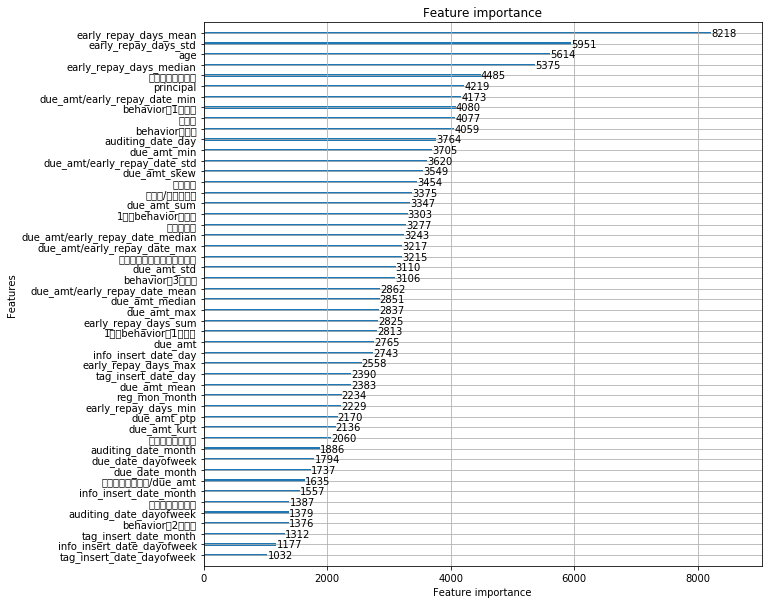

In [149]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
lgb.plot_importance(clf, max_num_features=50,figsize=(10,10))

In [143]:
sub_example['prob'] = test_prob

In [144]:
threshold_up = 0.57
id_with_highpro = sub_example[sub_example['prob']>=threshold_up]['listing_id']

In [145]:
sub_example.loc[sub_example['listing_id'].isin(id_with_highpro.values),'repay_amt']=0

In [146]:
sub_example['repay_amt']= sub_example.apply(lambda x:x['repay_amt'] if x['prob']<threshold_up else x['due_amt'],axis=1)

In [147]:
sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_0_{threshold_up}.csv", index=False)

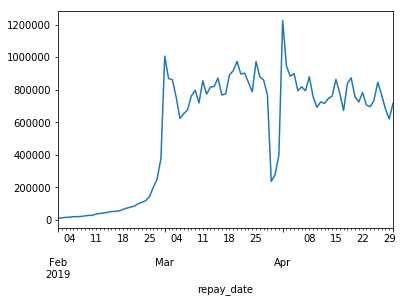

In [148]:
sub_example.groupby('repay_date').apply(lambda x:x['repay_amt'].sum()).plot(kind='line')

def alter(df, date, a):
    """
    data就是要增加的日期
    a就是这天增加的比例
    """
    if date not in df['repay_date'].values:
        return df
    else:
        dates = df['repay_date'].tolist()
        dates.remove(date)
        df = df.set_index('repay_date')
        b = df.loc[date, 'repay_amt'] * a
        df.loc[date, 'repay_amt'] += b
        df.loc[dates, 'repay_amt'] -= b / len(dates)
        df.reset_index(inplace=True)
        return df

sub_example_1 = sub_example.copy()

sub_example_1['repay_date']=sub_example_1['repay_date'].astype(str)

sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-29", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-30", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]
sub_example_1 = sub_example_1.groupby('listing_id', as_index=False).apply(alter, date="2019-03-31", a=0.1).reset_index(drop=True)[['listing_id', 'repay_date', 'repay_amt']]

sub_example_1.to_csv("sub_ex.csv",index=False)

# 下面这行的结果告诉我一下

In [ ]:
#df_bkup = sub_example.copy()

In [ ]:
#sub_example['prob'] = test_prob 

In [ ]:
#sub_example.sort_values(by='prob',ascending = False).drop_duplicates('listing_id').reset_index(drop=True).prob.describe()

In [ ]:
#for threshold in [0.1, 0.15, 0.2, 0.25]:  # 这里的threshold可以根据上面给我看的describe进行修改
#    sub_example['repay_amt'] = sub_example.apply(lambda x:x['due_amt'] * x['prob'] if x['prob'] > threshold else 0, axis=1)
#    sub_example[['listing_id', 'repay_date', 'repay_amt']].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_{threshold}.csv", index=False)


In [ ]:
#for threshold in [0.1, 0.15, 0.2, 0.25]:  # 这里的threshold可以根据上面给我看的describe进行修改
#    sub_example['repay_amt'] = sub_example.apply(lambda x:x['due_amt'] * x['prob'] if x['prob'] > threshold else 0, axis=1)
#    sub_example_fin=sub_example[['listing_id', 'repay_date', 'repay_amt']]
#    sub_example_fin[sub_example_fin['repay_amt']!=0].to_csv(f"sub_{datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')}_{threshold}.csv", index=False)